In [1]:
import os
import pandas as pd
from PIL import Image

# 데이터셋 경로 설정
dataset_path = '../ultralytics/datasets/TLD_2024/tld_db'
train_path = os.path.join(dataset_path, 'train')
labels_path = os.path.join(train_path, 'labels').replace('\\', '/')

# 클래스 정의
classes = [
    "veh_go", "veh_goLeft", "veh_noSign", "veh_stop", "veh_stopLeft",
    "veh_stopWarning", "veh_warning", "ped_go", "ped_noSign", "ped_stop",
    "bus_go", "bus_noSign", "bus_stop", "bus_warning"
]

train_df = pd.DataFrame()

image_ids = []
class_names = []
class_ids = []
x_min = []
y_min = []
x_max = []
y_max = []

# 훈련 데이터 디렉토리 순회
for filename in os.listdir(labels_path):
    if filename.endswith('.txt'):
        image_id = os.path.splitext(filename)[0]
        image_path = os.path.join(train_path, 'images', f"{image_id}.jpg")
        label_path = os.path.join(train_path, 'labels', filename)
        
        # 이미지 크기 가져오기
        with Image.open(image_path) as img:
            img_width, img_height = img.size
        
        # 레이블 파일 읽기
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                
                # YOLO 형식을 (x_min, y_min, x_max, y_max) 형식으로 변환
                x_min_val = (x_center - width/2) * img_width
                y_min_val = (y_center - height/2) * img_height
                x_max_val = (x_center + width/2) * img_width
                y_max_val = (y_center + height/2) * img_height
                
                image_ids.append(f"{image_id}.jpg")
                class_names.append(classes[int(class_id)])
                class_ids.append(int(class_id))
                x_min.append(x_min_val)
                y_min.append(y_min_val)
                x_max.append(x_max_val)
                y_max.append(y_max_val)

# DataFrame 생성
train_df['image_id'] = image_ids
train_df['class_name'] = class_names
train_df['class_id'] = class_ids
train_df['x_min'] = x_min
train_df['y_min'] = y_min
train_df['x_max'] = x_max
train_df['y_max'] = y_max

# DataFrame 출력
print(train_df.head())

       image_id class_name  class_id      x_min      y_min      x_max  \
0  00000000.jpg   veh_stop         3  690.00064  165.00000  703.00032   
1  00000000.jpg   veh_stop         3  709.00032  163.99992  722.99968   
2  00000001.jpg   veh_stop         3  657.00032  157.99992  670.99968   
3  00000001.jpg   veh_stop         3  677.00032  156.99984  690.99968   
4  00000002.jpg   veh_stop         3  632.99968  149.99976  645.99936   

       y_max  
0  171.00000  
1  169.00008  
2  163.00008  
3  162.99984  
4  154.99992  


In [2]:
import plotly.express as px

fig = px.histogram(train_df.image_id.value_counts(), 
                   log_y=True, color_discrete_sequence=['indianred'], opacity=0.7,
                   labels={"value":"Number of Annotations Per Image"},
                   title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER IMAGE   " \
                         "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )
fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique Images</b>",
                  yaxis_title="<b>Count of All Object Annotations</b>",)
fig.show()

In [3]:
fig = px.histogram(train_df.groupby('image_id')["class_id"].unique().apply(lambda x: len(x)), 
             log_y=True, color_discrete_sequence=['skyblue'], opacity=0.7,
             labels={"value":"Number of Unique class"},
             title="<b>DISTRIBUTION OF # OF Unique Class PER IMAGE   " \
                   "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )
fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique CLASS</b>",
                  yaxis_title="<b>Count of Unique IMAGE</b>",)
fig.show()

In [4]:
import seaborn as sns

LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

fig = px.bar(train_df.class_name.value_counts().sort_index(), 
             color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class</b>")

fig.update_layout(legend_title=None,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>",
                  yaxis=dict(rangemode='nonnegative'))  # y축을 0부터 시작하도록 설정

fig.show()

100%|██████████| 87617/87617 [00:00<00:00, 240678.88it/s]


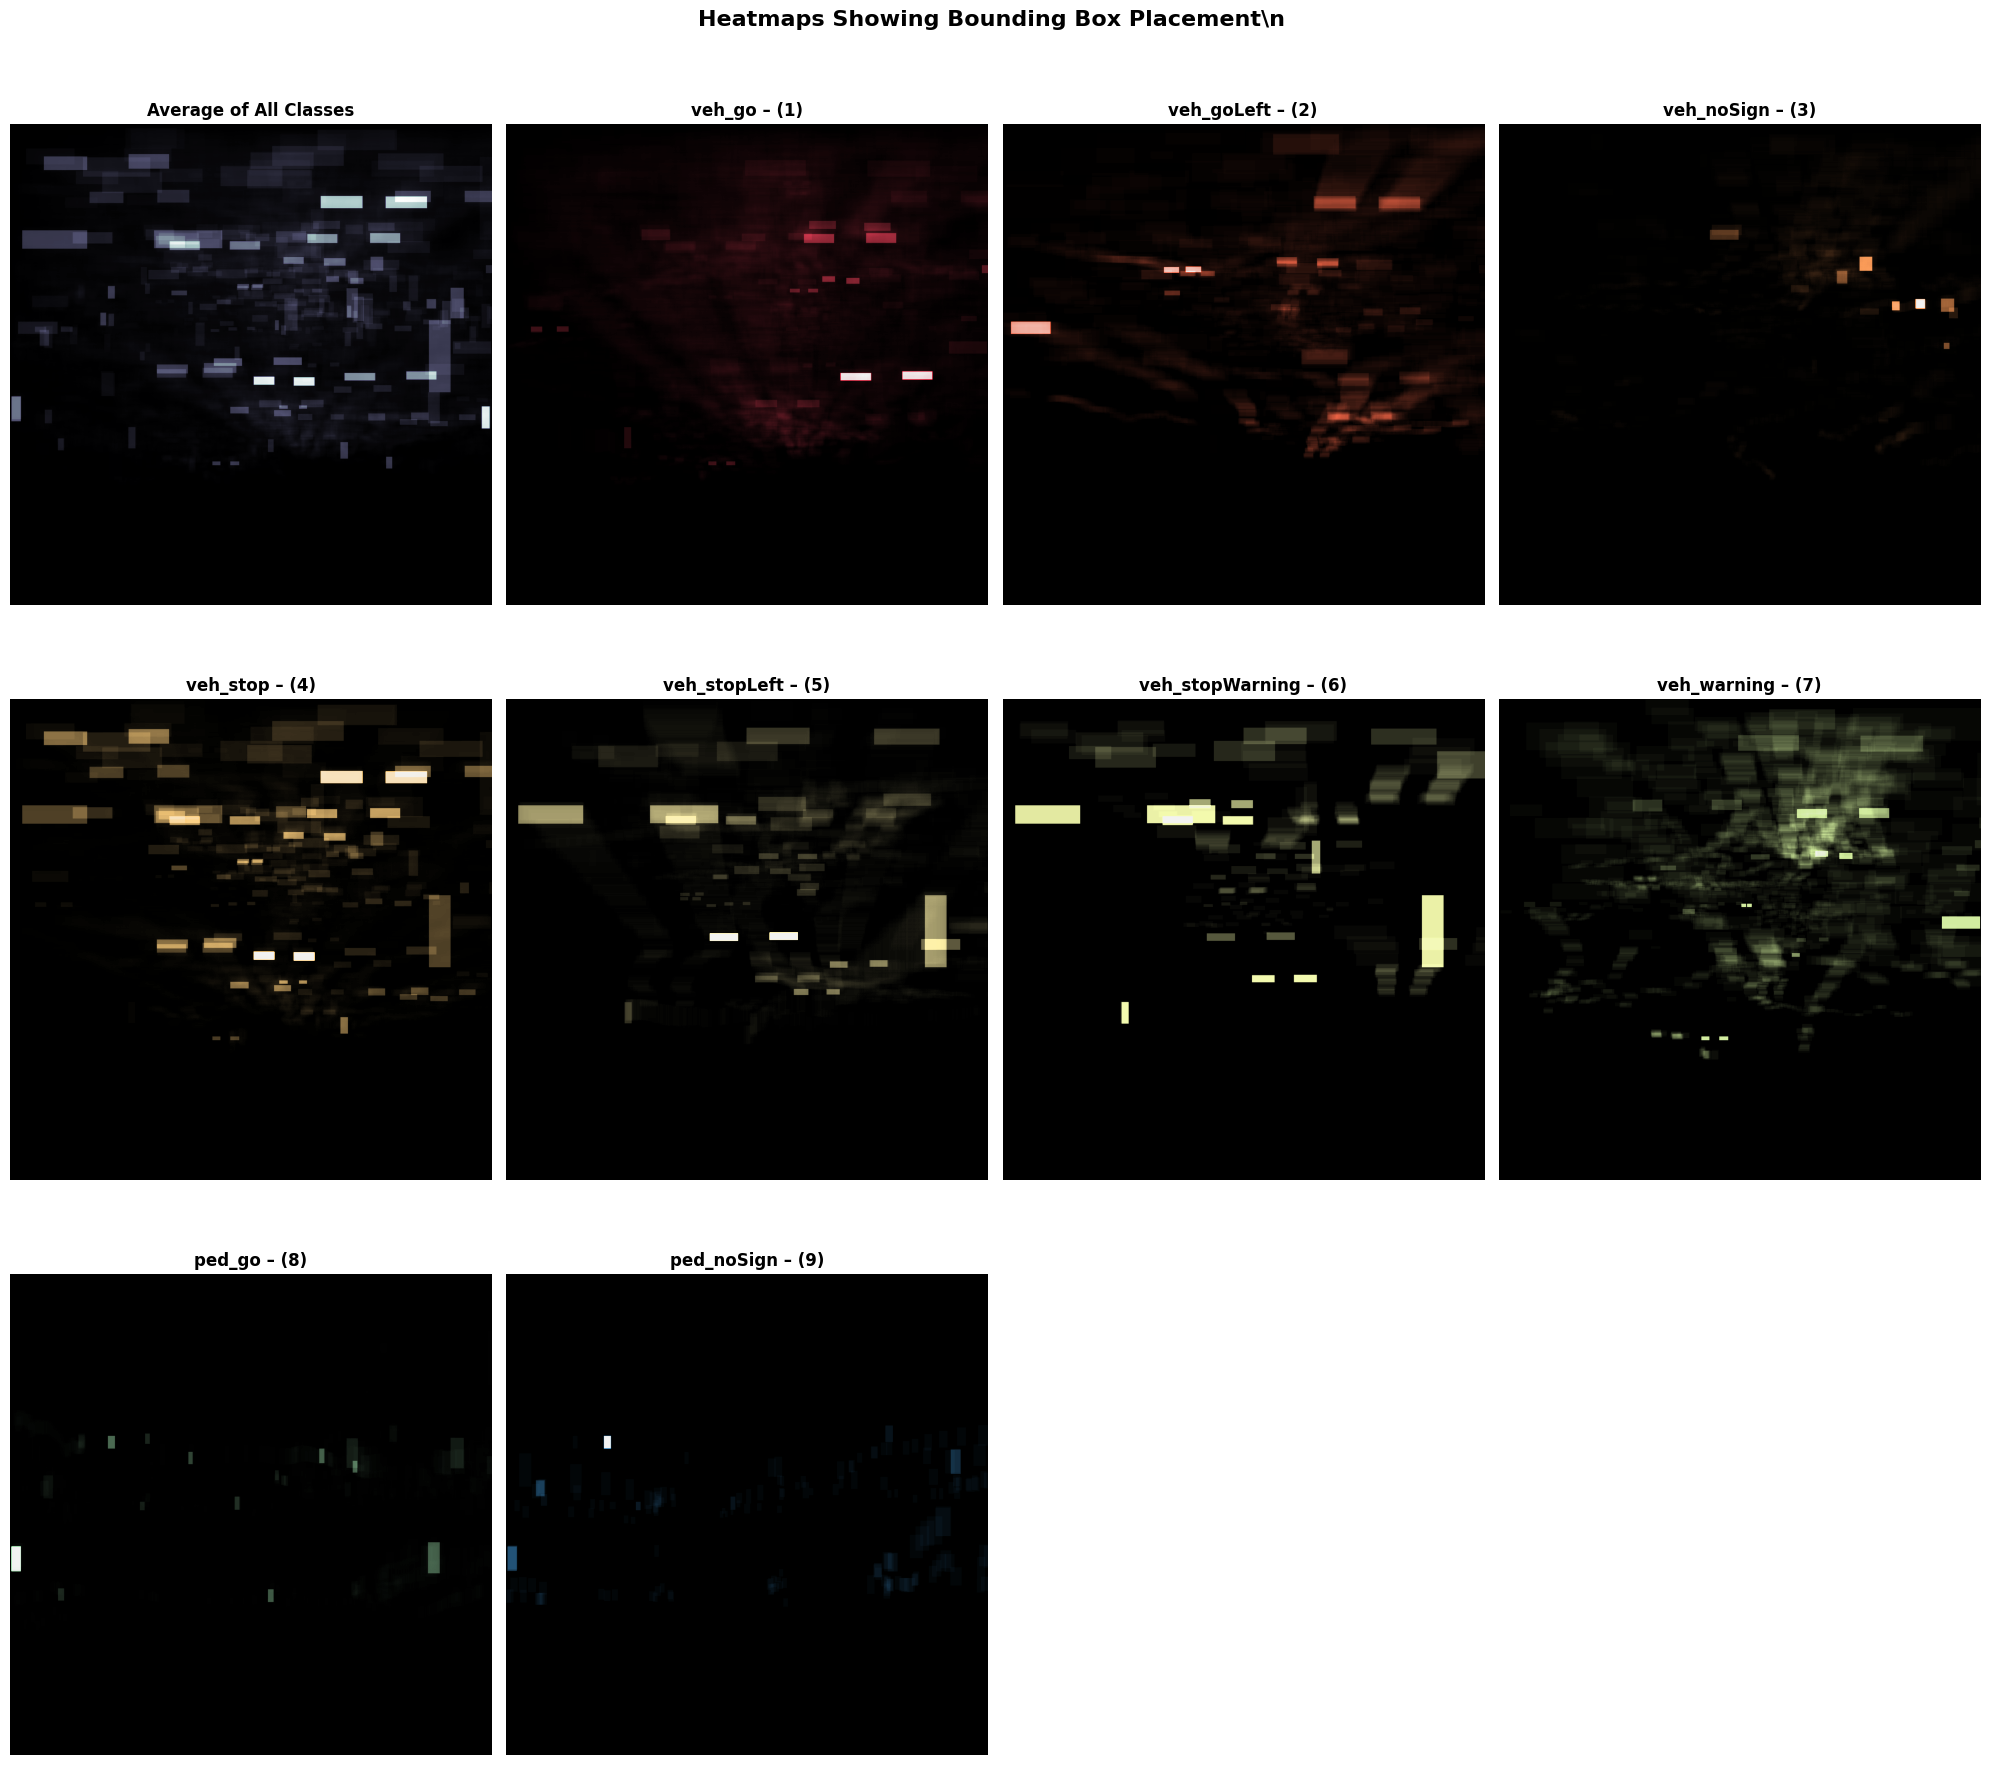

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib

bbox_df = pd.DataFrame()
bbox_df['class_id'] = train_df['class_id'].values
bbox_df['class_name'] = train_df['class_name'].values
bbox_df['x_min'] = train_df['x_min'].values / 1024
bbox_df['x_max'] = train_df['x_max'].values / 1024
bbox_df['y_min'] = train_df['y_min'].values / 1024
bbox_df['y_max'] = train_df['y_max'].values / 1024
bbox_df['frac_x_min'] = train_df['x_min'].values / 1024
bbox_df['frac_x_max'] = train_df['x_max'].values / 1024
bbox_df['frac_y_min'] = train_df['y_min'].values / 1024
bbox_df['frac_y_max'] = train_df['y_max'].values / 1024

ave_src_img_height = 1024
ave_src_img_width = 1024

# DEFAULT
HEATMAP_SIZE = (ave_src_img_height, ave_src_img_width, 14)

# Initialize
heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bbox_np = bbox_df[["class_id", "frac_x_min", "frac_x_max", "frac_y_min", "frac_y_max"]].to_numpy()
bbox_np[:, 1:3] *= ave_src_img_width
bbox_np[:, 3:5] *= ave_src_img_height
bbox_np = np.floor(bbox_np).astype(np.int16)

# Color map stuff
custom_cmaps = [
    matplotlib.colors.LinearSegmentedColormap.from_list(
        colors=[(0.,0.,0.), c, (0.95,0.95,0.95)], 
        name=f"custom_{i}") for i,c in enumerate(sns.color_palette("Spectral", 10))
]
custom_cmaps.pop(8) # Remove No-Finding

for row in tqdm(bbox_np, total=bbox_np.shape[0]):
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1
    
fig = plt.figure(figsize=(20,25))
plt.suptitle("Heatmaps Showing Bounding Box Placement\\n ", fontweight="bold", fontsize=16)
for i in range(10):
    plt.subplot(4, 4, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Average of All Classes", fontweight="bold")
    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{classes[i-1]} – ({i})", fontweight="bold")
        
    plt.axis(False)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

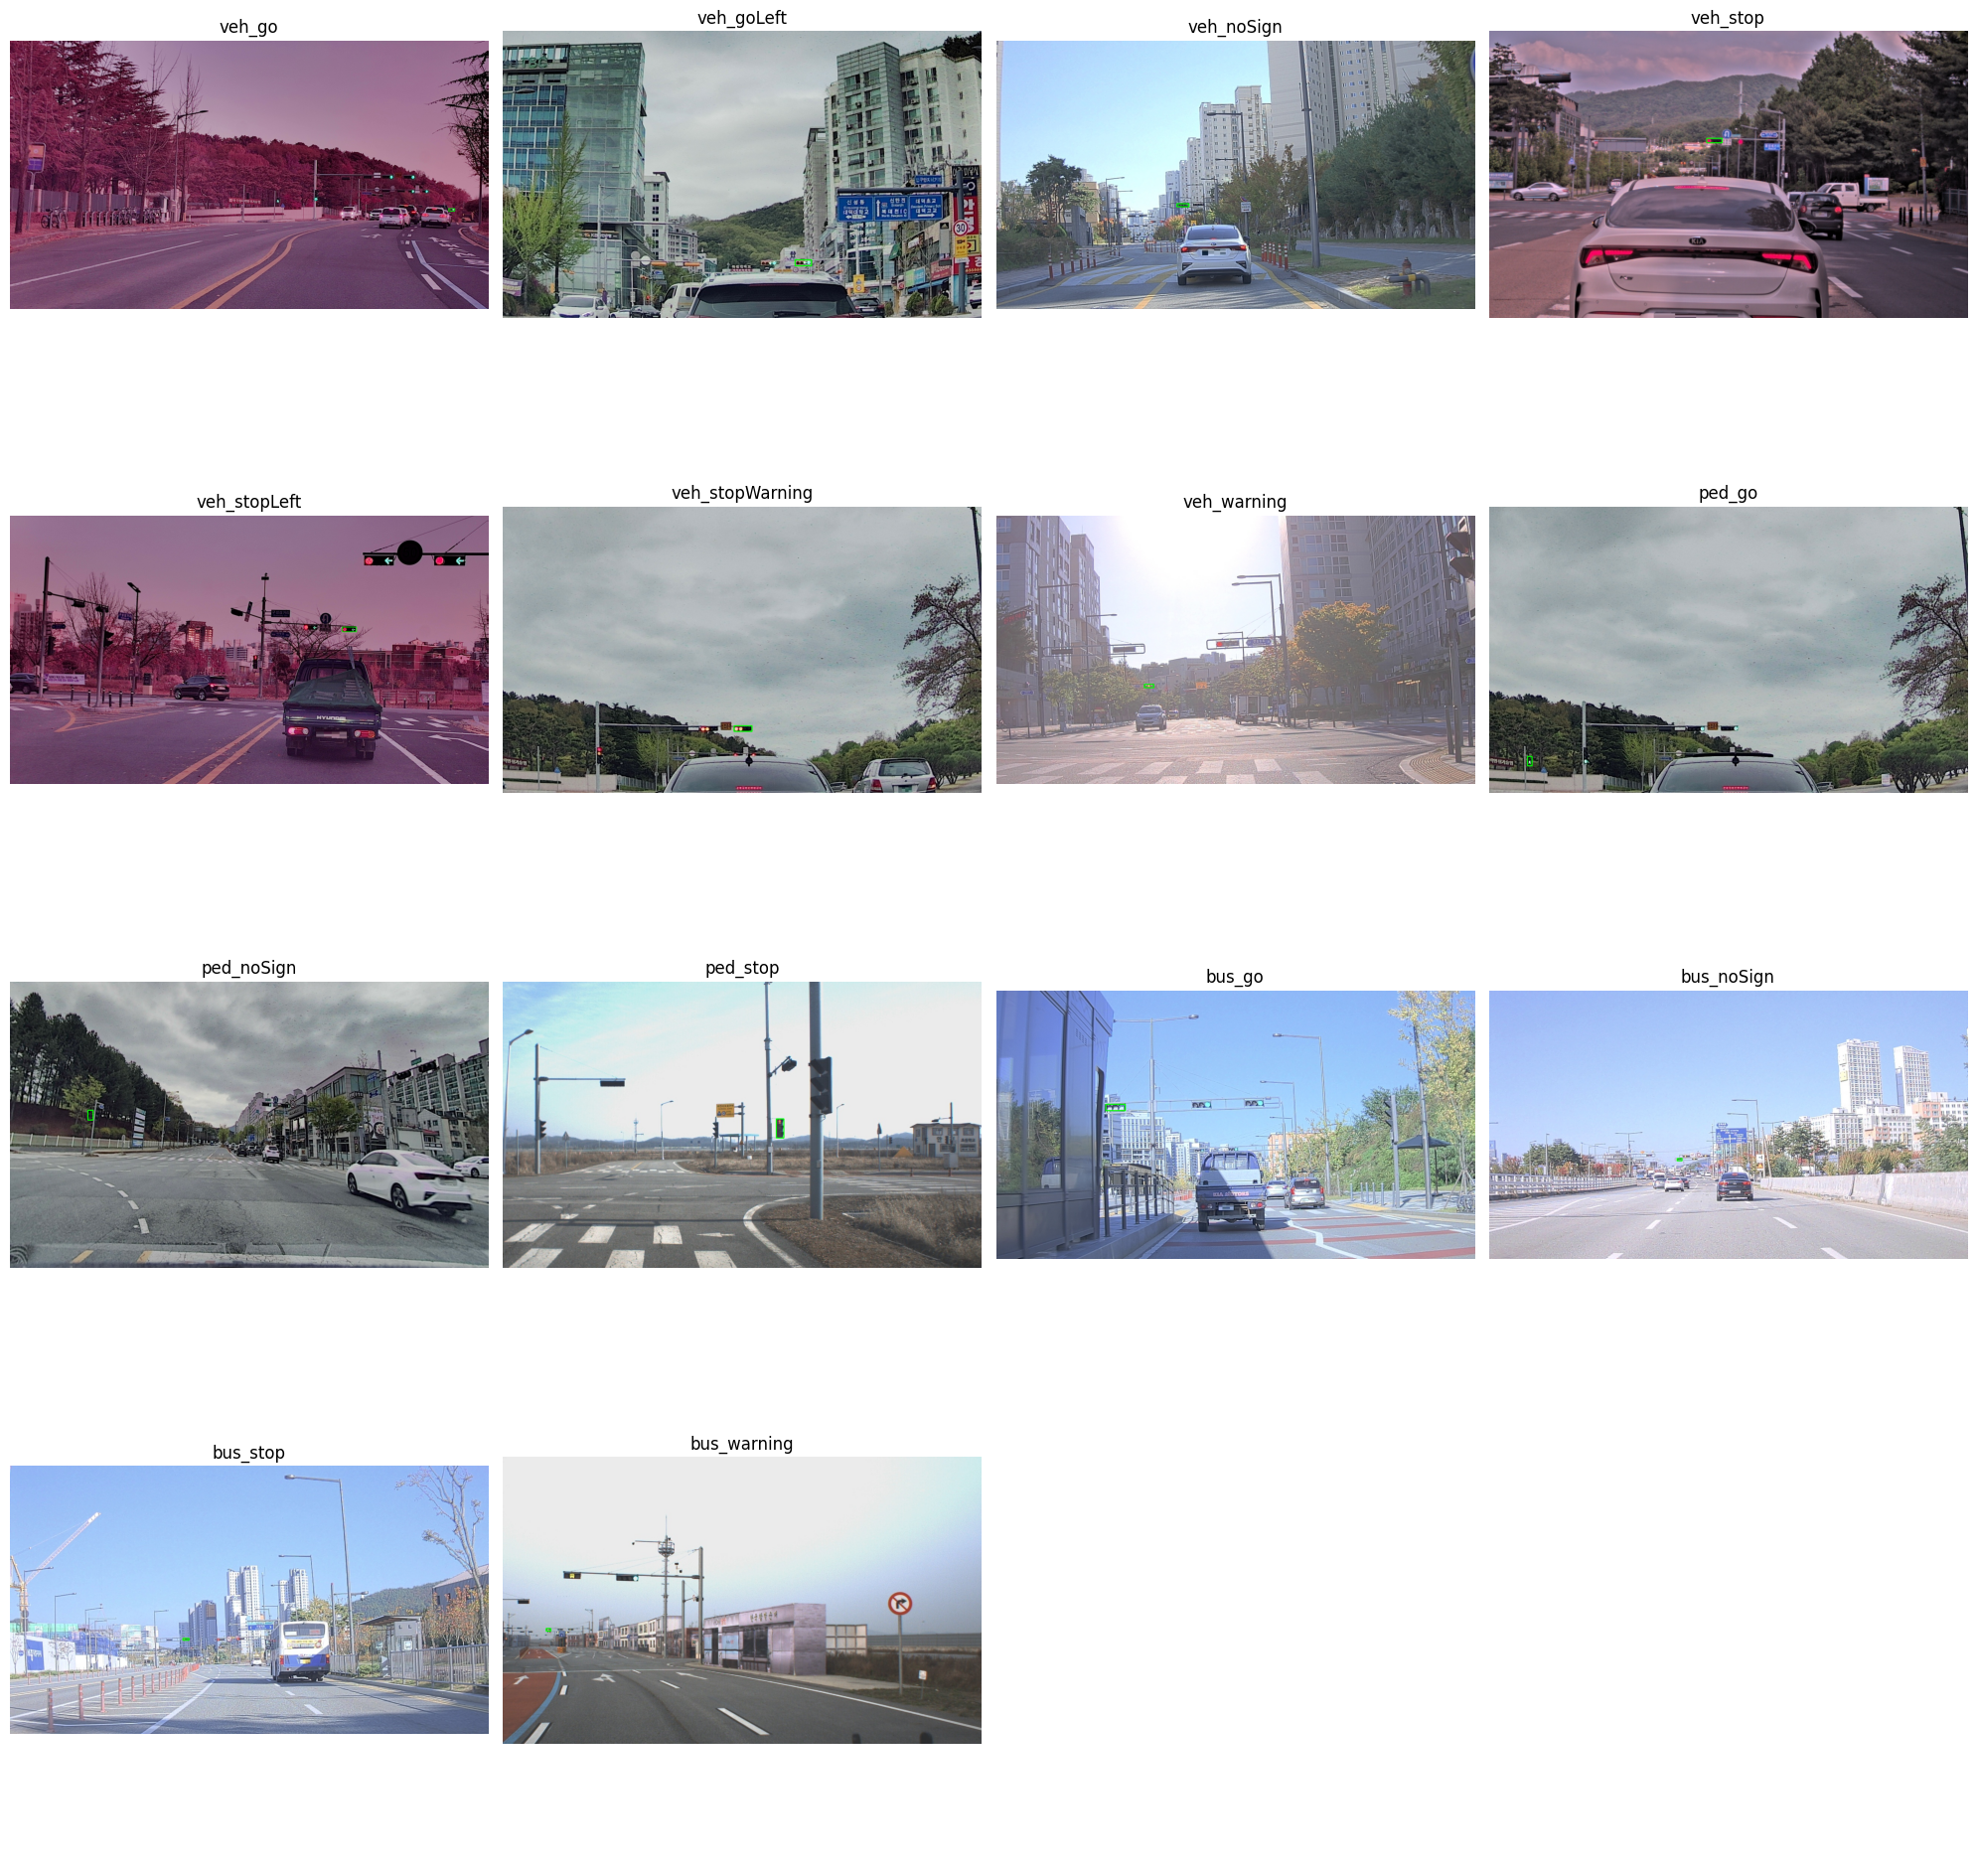

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

def draw_box(image, box, color=(0, 255, 0), thickness=2):
    x_min, y_min, x_max, y_max = map(int, box)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)
    return image

def show_sample_images(df, classes, image_dir, num_cols=4):
    num_classes = len(classes)
    num_rows = (num_classes + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
    axes = axes.flatten()
    
    for i, class_name in enumerate(classes):
        class_df = df[df['class_name'] == class_name]
        if len(class_df) == 0:
            continue
        
        sample = class_df.sample(1).iloc[0]
        image_path = f"{image_dir}/{sample['image_id']}"
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        box = [sample['x_min'], sample['y_min'], sample['x_max'], sample['y_max']]
        image_with_box = draw_box(image.copy(), box)
        
        axes[i].imshow(image_with_box)
        axes[i].set_title(f"{class_name}")
        axes[i].axis('off')
    
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# 이미지 디렉토리 경로 설정
image_dir = '../ultralytics/datasets/TLD_2024/tld_db/train/images'

# 함수 호출
show_sample_images(train_df, classes, image_dir)

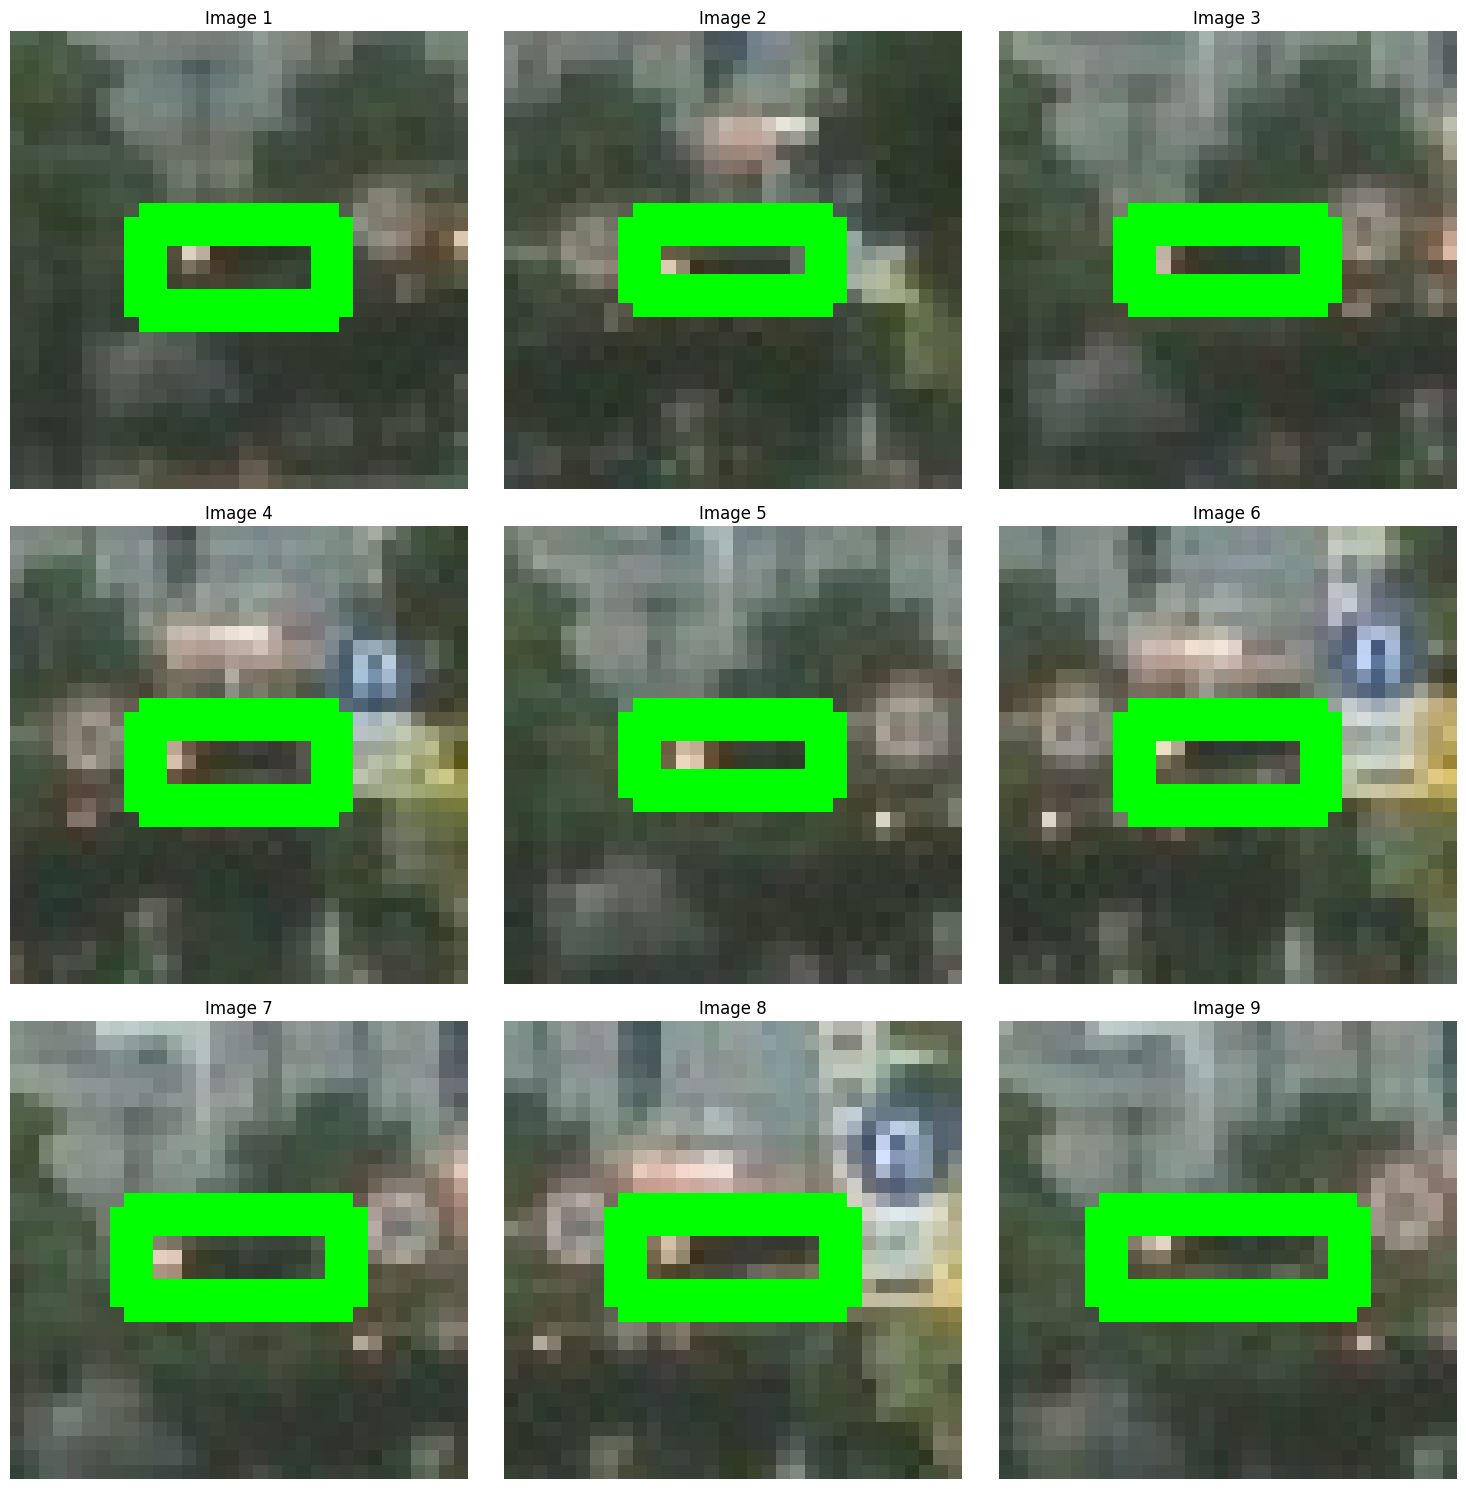

In [9]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

def draw_box(image, box, color=(0, 255, 0), thickness=1):
    h, w = image.shape[:2]
    x_center, y_center, width, height = box
    x_min = int((x_center - width/2) * w)
    y_min = int((y_center - height/2) * h)
    x_max = int((x_center + width/2) * w)
    y_max = int((y_center + height/2) * h)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)
    return image

def visualize_cropped_images(image_dir, label_dir, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()

    image_files = sorted(os.listdir(image_dir))[:num_images]

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                line = f.readline().strip().split()
                class_id, x_center, y_center, width, height = map(float, line)
                image = draw_box(image, (x_center, y_center, width, height))

        axes[i].imshow(image)
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 사용 예
cropped_dataset_dir = '../ultralytics/datasets/TLD_2024/tld_db/train_cropped'
cropped_image_dir = os.path.join(cropped_dataset_dir, 'images')
cropped_label_dir = os.path.join(cropped_dataset_dir, 'labels')

visualize_cropped_images(cropped_image_dir, cropped_label_dir)